In [1]:
#Use huggingface transformers library for ESM model
import os
os.chdir('/home/azamh/bioinf')
import sys
from transformers import EsmTokenizer, EsmModel, EsmForSequenceClassification
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np
import torch
from utils.parse_data import *
from utils.rep3d import *
from utils.visuallize import *
from script.models import *
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
torch.backends.cudnn.benchmark = True
from sklearn.metrics import accuracy_score, matthews_corrcoef, classification_report, f1_score


%load_ext autoreload
%autoreload 2

/home/azamh/anaconda3/envs/pyuul/envs/esm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Get device 
device = get_device()
print(device)

NVIDIA GeForce RTX 2080 Ti
cuda


In [3]:
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 2080 Ti


In [4]:
#Train ESM model to predict localization
#repo = 'facebook/esm2_t6_8M_UR50D'
#repo = 'facebook/esm2_t12_35M_UR50D'
repo = 'facebook/esm2_t30_150M_UR50D'
#repo = 'facebook/esm2_t33_650M_UR50D'
#repo = 'facebook/esm2_t36_3B_UR50D'
#repo = 'facebook/esm2_t48_15B_UR50D'

#Load tokenizer and model
tokenizer = EsmTokenizer.from_pretrained(repo)
#esm_classifier = nn.DataParallel(EsmForSequenceClassification.from_pretrained(repo, num_labels = 10))
esm_classifier = EsmForSequenceClassification.from_pretrained(repo, num_labels = 10)

if torch.cuda.is_available():
    esm_classifier.cuda()
    print('N Gpus:', torch.cuda.device_count())

Some weights of the model checkpoint at facebook/esm2_t30_150M_UR50D were not used when initializing EsmForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', '

N Gpus: 4


In [5]:
#Read in deeploc dataset
deeploc_df = read_deep_loc()

#Drop extremely large sequences
max_len = 500
for index in deeploc_df.index:
    if len(deeploc_df['Sequence'][index]) > max_len:
        deeploc_df = deeploc_df.drop(index)

deeploc_df

,Protein,Sequence,Location,Extra Location,Split,Location Label
10700,Q9DA32,MPRTRNIGALCTLPEDTTHSGRPRRGVQRSYISRMAEPAPANMNDP...,Nucleus,M,train,0
10701,O42927,MNPTSFIYDKPPPPPIINKPFEQTNSSASLTQKNSSSETENVGRHG...,Nucleus,U,test,0
10704,Q8TAS1,MAGSGCAWGAEPPRFLEAFGRLWQVQSRLGSGSSASVYRVRCCGNP...,Nucleus,U,train,0
10706,Q96WW3,MAKSARSKSIRRNKKVLRENVFQPVIDERTKRLSAHLRDQVNDLTK...,Nucleus,U,train,0
10708,Q8VYI0,MAATTGLETLVDQIISVITNDGRNIVGVLKGFDQATNIILDESHER...,Nucleus,U,train,0
...,...,...,...,...,...,...
11076,Q9S850,MPGIRGPSEYSQEPPRHPSLKVNAKEPFNAEPPRSALVSSYVTPVD...,Peroxisome,U,test,9
11075,P11930,MSSSSSWRRAATVMLAAGWTHSSPAGFRLLLLQRAQNQRFLPGAHV...,Peroxisome,U,train,9
11074,Q9LRS0,MEITNVTEYDAIAKAKLPKMVYDYYASGAEDQWTLQENRNAFARIL...,Peroxisome,U,train,9
11073,A2AKK5,MMIKLIATPSNALVDEPVSIRATGLPPSQIVTIKATVKDENDNVFQ...,Peroxisome,U,train,9


In [6]:
#Add AF2 models to deeploc dataset
deeploc_af2_df = get_deep_loc_af2(deeploc_df)
deeploc_af2_df

,Protein,Sequence,Location,Extra Location,Split,Location Label,PDB Path
10700,Q9DA32,MPRTRNIGALCTLPEDTTHSGRPRRGVQRSYISRMAEPAPANMNDP...,Nucleus,M,train,0,data/deeploc_af2/AF-Q9DA32-F1-model_v4.pdb
10701,O42927,MNPTSFIYDKPPPPPIINKPFEQTNSSASLTQKNSSSETENVGRHG...,Nucleus,U,test,0,data/deeploc_af2/AF-O42927-F1-model_v4.pdb
10704,Q8TAS1,MAGSGCAWGAEPPRFLEAFGRLWQVQSRLGSGSSASVYRVRCCGNP...,Nucleus,U,train,0,data/deeploc_af2/AF-Q8TAS1-F1-model_v4.pdb
10706,Q96WW3,MAKSARSKSIRRNKKVLRENVFQPVIDERTKRLSAHLRDQVNDLTK...,Nucleus,U,train,0,data/deeploc_af2/AF-Q96WW3-F1-model_v4.pdb
10708,Q8VYI0,MAATTGLETLVDQIISVITNDGRNIVGVLKGFDQATNIILDESHER...,Nucleus,U,train,0,data/deeploc_af2/AF-Q8VYI0-F1-model_v4.pdb
...,...,...,...,...,...,...,...
11076,Q9S850,MPGIRGPSEYSQEPPRHPSLKVNAKEPFNAEPPRSALVSSYVTPVD...,Peroxisome,U,test,9,data/deeploc_af2/AF-Q9S850-F1-model_v4.pdb
11075,P11930,MSSSSSWRRAATVMLAAGWTHSSPAGFRLLLLQRAQNQRFLPGAHV...,Peroxisome,U,train,9,data/deeploc_af2/AF-P11930-F1-model_v4.pdb
11074,Q9LRS0,MEITNVTEYDAIAKAKLPKMVYDYYASGAEDQWTLQENRNAFARIL...,Peroxisome,U,train,9,data/deeploc_af2/AF-Q9LRS0-F1-model_v4.pdb
11073,A2AKK5,MMIKLIATPSNALVDEPVSIRATGLPPSQIVTIKATVKDENDNVFQ...,Peroxisome,U,train,9,data/deeploc_af2/AF-A2AKK5-F1-model_v4.pdb


train    6664
test     1657
Name: Split, dtype: int64


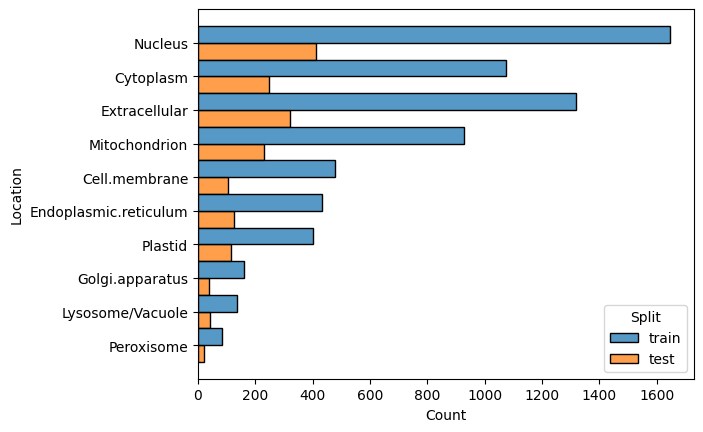

In [7]:
#Plot data with Af2 models
sns.histplot(data = deeploc_af2_df, y = 'Location', hue = 'Split', multiple = 'dodge', hue_order = ['train', 'test'])
print(deeploc_af2_df['Split'].value_counts())

In [8]:
#Voxel params
hashing = "Element_Hashing"
resolution = 1
rep = 'voxel'

#Generate resized voxels and save to file
deeploc_af2_df['Voxel Path'] = ''
voxel_dir = 'voxels/deeploc'
os.makedirs(voxel_dir, exist_ok = True)
for i in range(len(deeploc_af2_df)):
    if i % 1000 == 0: print(i)
    protein_path = deeploc_af2_df['PDB Path'].iloc[i]
    protein = deeploc_af2_df['Protein'].iloc[i]
    voxel_path = os.path.join(voxel_dir, f'{protein}.pt')
    deeploc_af2_df['Voxel Path'].iloc[i] = voxel_path
    
    #Generate voxel
    if not os.path.isfile(voxel_path):
        voxel = rep_protein(protein_path, device, rep = rep, hashing = hashing, resolution = resolution)
        resized_voxel = resize_grid(voxel.to_dense(), device, 5, 110, 110, 110)
        torch.save(resized_voxel.cpu(), voxel_path)

0
1000
2000
3000
4000
5000
6000
7000
8000


train    6664
test     1657
Name: Split, dtype: int64


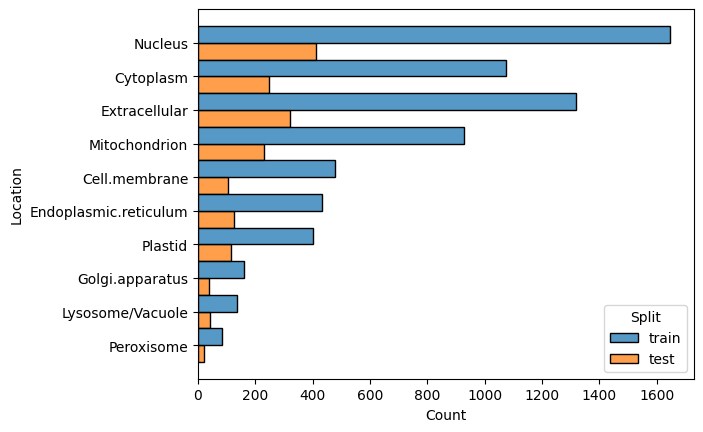

In [9]:
sns.histplot(data = deeploc_af2_df, y = 'Location', hue = 'Split', multiple = 'dodge', hue_order = ['train', 'test'])
print(deeploc_af2_df['Split'].value_counts())

In [10]:
#Split dataset and create dataloader
pin_memory = True
if device == 'cpu':
    pin_memory = False
num_workers = 0
batch_size = 4
train_deeploc_af2_df, test_deeploc_af2_df = split_deeploc(deeploc_af2_df)

#Voxels:
#Create dataset
voxel_train_set = VoxelDataset(list(train_deeploc_af2_df['Voxel Path']), list(train_deeploc_af2_df['Location Label']))
voxel_test_set = VoxelDataset(list(test_deeploc_af2_df['Voxel Path']), list(test_deeploc_af2_df['Location Label']))

#Create loaders
voxel_train_loader = torch.utils.data.DataLoader(voxel_train_set, batch_size=batch_size,
                                              shuffle=True, num_workers = num_workers, pin_memory=pin_memory)
voxel_test_loader = torch.utils.data.DataLoader(voxel_test_set, batch_size=batch_size,
                                              shuffle=True, num_workers = num_workers, pin_memory=pin_memory) 

#Tokens
#Create dataset
token_train_set = TokenDataset(list(train_deeploc_af2_df['Sequence']), list(train_deeploc_af2_df['Location Label']), tokenizer, max_len)
token_test_set = TokenDataset(list(test_deeploc_af2_df['Sequence']), list(test_deeploc_af2_df['Location Label']), tokenizer, max_len)

#Create loaders
token_train_loader = torch.utils.data.DataLoader(token_train_set, batch_size=batch_size,
                                              shuffle=True, num_workers = num_workers, pin_memory=pin_memory)
token_test_loader = torch.utils.data.DataLoader(token_test_set, batch_size=batch_size,
                                              shuffle=True, num_workers = num_workers, pin_memory=pin_memory) 

In [11]:
# Cross Entropy Loss 
loss_fn = nn.CrossEntropyLoss()

# SGD Optimizer
optimizer = torch.optim.Adam(esm_classifier.parameters(), lr = .000005)

In [12]:
# ESM model training
model_save_path = f'models/{repo}'
epochs = 3

esm_classifier = train_model(esm_classifier, 
            epochs, 
            model_save_path, 
            token_train_loader,
            token_test_loader,
            optimizer,
            loss_fn,
            device,
            esm = True)


In [13]:
#Predict all   
if not os.path.isfile('data/esm_pred/deeploc_af2_df.xlsx'):
    deeploc_af2_df['ESM Pred'] = np.nan
    esm_classifier.eval()
    with torch.no_grad():
        for i, index in enumerate(deeploc_af2_df.index):
            print(i)

            protein = deeploc_af2_df['Protein'][index]

            tokens = tokenizer(deeploc_af2_df['Sequence'][index], 
                      return_tensors="pt", 
                      max_length = max_len - 1, 
                      padding = "max_length", 
                      truncation=True).to(device)

            outputs = esm_classifier(**tokens,  output_hidden_states=True)
            logits = outputs.logits
            last_hidden_state = outputs.hidden_states[-1]
            features = last_hidden_state[:, 0, :]
            _, predictions = torch.max(logits, 1)
            predictions = predictions.tolist()[0]

            #Add prediction to dataframe
            deeploc_af2_df['ESM Pred'][index] = predictions

            #Save hidden state to file                
            torch.save(features.cpu(), f'esm_encoding/{protein}.pt')

            del tokens
            del outputs

    #Save dataframe
    deeploc_af2_df.to_excel('data/esm_pred/deeploc_af2_df.xlsx')
else:
    deeploc_af2_df = pd.read_excel('data/esm_pred/deeploc_af2_df.xlsx', header = 0, index_col = 0)

In [14]:
#Get accuracy and f1 score
train_deeploc_af2_df, test_deeploc_af2_df = split_deeploc(deeploc_af2_df)
train_acc = accuracy_score(train_deeploc_af2_df['Location Label'], train_deeploc_af2_df['ESM Pred'])
test_acc = accuracy_score(test_deeploc_af2_df['Location Label'], test_deeploc_af2_df['ESM Pred'])
train_f1 = f1_score(train_deeploc_af2_df['Location Label'], train_deeploc_af2_df['ESM Pred'], average = 'macro')
test_f1 = f1_score(test_deeploc_af2_df['Location Label'], test_deeploc_af2_df['ESM Pred'], average = 'macro')
print(train_acc, train_f1)
print(test_acc, test_f1)

0.9242196878751501 0.7663098680545771
0.8032589016294508 0.6158978910460566
